# Manual:

En el dashboard el usuario debe seleccionar:

0. Fecha inicio de la grafica (Periodo inicial)
1. Fecha de choque (date)
2. Modelo de forecasting (model0)
3. Definir si el choque es acumulativo o no
4. Variable que recibe el choque (var)
5. Magnitud del choque (magnitud_de_choque)
6. Definir si va con convergencia al forecasting o no

0. Periodo Inicial: entero de 0 a 7865, donde 0 = '2000-01-01' y 7865 = '2021-07-14'
1. Fecha de choque (date): se ingresa de la forma **'2021-12-31'** tiene que ser mayor a '2021-07-14'
2. Modelo de forecasting (modelo), puede ser alguno de los siguientes: \
'kW/h price ARIMA', \
'kW/h price SARIMAX', \
'kW/h price Neural Prophet', \
'kW/h price mean models'.
3. Si el choque es acumulativo debe seleccionar una de las siguientes variables (var): \
'Cumulative_HYDRAULIC availability', \
'Cumulative_THERMAL availability', \
'Cumulative_flow_contribution', \
'Cumulative_daily_volume_(Mm3)', \
'Cumulative_Volume_(Mm3)', \
'Cumulative_Daily_useful_Volume_(gWh)'
4. Si el choque no es acumulativo debe seleccionar una de las siguientes variables (var): \
'HYDRAULIC_availability' \
'THERMAL_availability' \
'flow_contribution' \
'daily_volume_(Mm3)' \
'Volume_(Mm3)' \
'Daily_useful_Volume_(gWh)'

5. Magnitud del choque (magnitud_de_choque) es un valor porcentual que puede variar a disposición del usuario. Ejemplo: al ingresar -15, la función lo interpreta como una caída del 15% en la variable que se está chocando, y elabora la correspondiente simulación del efecto. en el pronóstico del precio.
6. Si el choque es con convergencia al forecasting del modelo debe usar la funcion:  **simular_choque_con_convergencia()** \
si no es con convergencia aplica la funcion: **simular_choque()**

# Librerias:

In [1]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.float_format='{:,.4f}'.format

# Cargando Archivos:

In [2]:
original_df = pd.read_excel('/content/original series.xlsx')
original_df = original_df.set_index('Date')


forecast_df = pd.read_excel('/content/series forecast.xlsx')
forecast_df = forecast_df.set_index('Date')


forecast_diff_df = pd.read_excel('/content/series forecast diff.xlsx')
forecast_diff_df = forecast_diff_df.set_index('Date')


with open('/content/impulse_responses.json', 'r') as f:
    impulse_response = json.load(f)

# Funciones:

In [3]:
forecast_df['Year'] = forecast_df.index.year
forecast_df['Month'] = forecast_df.index.month
original_df['Year'] = original_df.index.year
original_df['Month'] = original_df.index.month

In [32]:
def factor_de_expansion(variable,magnitud_de_choque):
  if variable == 'HYDRAULIC_availability':
    factor =  magnitud_de_choque * 2.9
  elif variable == 'THERMAL_availability':
    factor = magnitud_de_choque * 3
  elif variable == 'flow_contribution':
    factor = magnitud_de_choque * 15
  elif variable == 'daily_volume_(Mm3)':
    factor = magnitud_de_choque * 2.355
  elif variable == 'Volume_(Mm3)':
    factor = magnitud_de_choque * 2.4
  elif variable == 'Daily_useful_Volume_(gWh)':
    factor = magnitud_de_choque * 2.93
  if variable == 'Cumulative_HYDRAULIC availability':
    factor = magnitud_de_choque * 2.9
  elif variable == 'Cumulative_THERMAL availability':
    factor = magnitud_de_choque * 2.5
  elif variable == 'Cumulative_flow_contribution':
    factor = magnitud_de_choque * 15
  elif variable == 'Cumulative_daily_volume_(Mm3)':
    factor = magnitud_de_choque * 2.355
  elif variable == 'Cumulative_Volume_(Mm3)':
    factor = magnitud_de_choque * 2.4
  elif variable == 'Cumulative_Daily_useful_Volume_(gWh)':
    factor = magnitud_de_choque * 2.93
  return factor

In [6]:
def graficar(periodo_inicial):
  fig, ax = plt.subplots(figsize=(20,7))
  sns.lineplot(data=original_df['kW/h price mean'][periodo_inicial:], label='actual price')
  sns.lineplot(data=forecast_df['kW/h price ARIMA'], label='univariate model forecast')
  sns.lineplot(data=forecast_df['kW/h price SARIMAX'], label='multivariate model forecast')
  sns.lineplot(data=forecast_df['kW/h price Neural Prophet'], label='neural prohpet model forecast')
  sns.lineplot(data=forecast_df['kW/h price mean models'], label='mean forecast')
  fig.suptitle('kW/h price forecasting',fontsize=20)
  plt.xlabel('Date',fontsize=15)
  plt.ylabel('kW/h price',fontsize=15)
  return plt.show()

In [7]:
def impulse_dataframe(date, var, magnitud_de_choque):
  impulse_dataframe = pd.DataFrame(impulse_response[var]) * magnitud_de_choque
  impulse_dataframe['Date'] = pd.date_range(start=date, periods=len(impulse_response[var]), freq='D')
  impulse_dataframe['Date'] = pd.to_datetime(impulse_dataframe['Date'])
  impulse_dataframe.columns = ['price response','Date']
  impulse_dataframe = impulse_dataframe.set_index('Date')
  impulse_dataframe
  return impulse_dataframe

In [8]:
def response_dataframe(date, modelo, var, magnitud_de_choque):
  modelo = str(modelo)+' diff'
  temp_dataframe = pd.concat([forecast_diff_df[modelo], 
                             impulse_dataframe(date, var, factor_de_expansion(var,magnitud_de_choque))], 
                             axis=1)
  temp_dataframe.columns = ['original', 'impulse']
  temp_dataframe = temp_dataframe.replace(np.nan, 0)
  temp_dataframe['response'] = temp_dataframe['original'] + temp_dataframe['impulse']
  return temp_dataframe

In [9]:
def original_level_after_shock(date, modelo, var, magnitud_de_choque):
  response = response_dataframe(date, modelo, var, magnitud_de_choque)['response'].tolist()
  origin = 83.2870833333333
  original_level_temp = []
  for i in range(0,len(response)):
    if i == 0:
      x = origin + response[0]
      original_level_temp.append(x)
    else:
      x = response[i] + original_level_temp[-1]
      original_level_temp.append(x)
  forecast_df = pd.DataFrame(original_level_temp)
  forecast_df['Date'] = pd.date_range(start='2021-07-15', periods=len(forecast_df), freq='D')
  forecast_df['Date'] = pd.to_datetime(forecast_df['Date'])
  forecast_df.columns = ['price response','Date']
  forecast_df = forecast_df.set_index('Date')
  return forecast_df


In [10]:
def simular_choque(periodo_inicial, date, modelo, var, magnitud_de_choque):
  fig, ax = plt.subplots(figsize=(20,7))
  sns.lineplot(data=original_df['kW/h price mean'][periodo_inicial:], label='actual price')
  sns.lineplot(data=forecast_df[modelo], label='model forecast')
  sns.lineplot(data=original_level_after_shock(date, modelo, var, factor_de_expansion(var,magnitud_de_choque)), palette='Greens')
  fig.suptitle('kW/h price forecasting',fontsize=20)
  plt.xlabel('Date',fontsize=15)
  plt.ylabel('kW/h price',fontsize=15)
  return plt.show()


In [11]:
def response_con_convergencia(date, modelo, var, magnitud_de_choque):
  temp_dataframe = pd.concat([forecast_df[modelo], impulse_dataframe(date, var, factor_de_expansion(var,magnitud_de_choque))], axis=1)
  temp_dataframe.columns = ['original', 'impulse']
  temp_dataframe = temp_dataframe.replace(np.nan, 0)
  temp_dataframe['response'] = temp_dataframe['original'] + temp_dataframe['impulse']
  return temp_dataframe

In [12]:
def original_level_after_shock_convergencia(date, modelo, var, magnitud_de_choque):
  response = response_con_convergencia(date, modelo, var, magnitud_de_choque)['response'].tolist()
  origin = 83.2870833333333
  original_level_temp = []
  for i in range(0,len(response)):
    if i == 0:
      x = response[0] #+ origin
      original_level_temp.append(x)
    else:
      x = response[i] #+ original_level_temp[-1]
      original_level_temp.append(x)
  forecast_df = pd.DataFrame(original_level_temp)
  forecast_df['Date'] = pd.date_range(start='2021-07-15', periods=len(forecast_df), freq='D')
  forecast_df['Date'] = pd.to_datetime(forecast_df['Date'])
  forecast_df.columns = ['price response','Date']
  forecast_df = forecast_df.set_index('Date')
  return forecast_df

In [13]:
def simular_choque_con_convergencia(periodo_inicial, date, modelo, var, magnitud_de_choque):
  fig, ax = plt.subplots(figsize=(20,7))
  sns.lineplot(data=original_df['kW/h price mean'][periodo_inicial:], label='actual price')
  sns.lineplot(data=forecast_df[modelo], label='model forecast')
  sns.lineplot(data=original_level_after_shock_convergencia(date, modelo, var, factor_de_expansion(var,magnitud_de_choque)), palette='Greens')
  fig.suptitle('kW/h price forecasting',fontsize=20)
  plt.xlabel('Date',fontsize=15)
  plt.ylabel('kW/h price',fontsize=15)
  return plt.show()

# Graficas de las series:

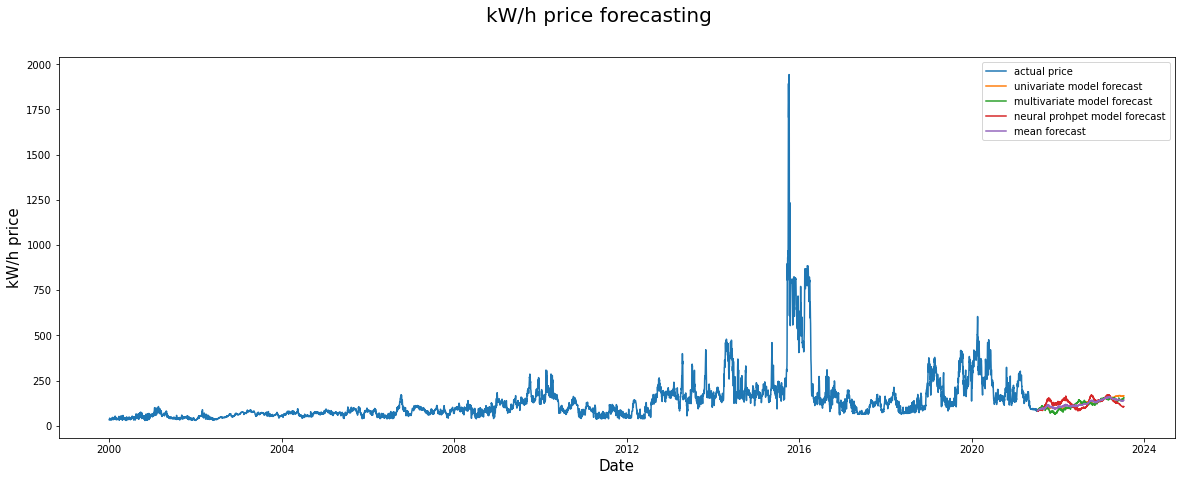

In [14]:
graficar(0)

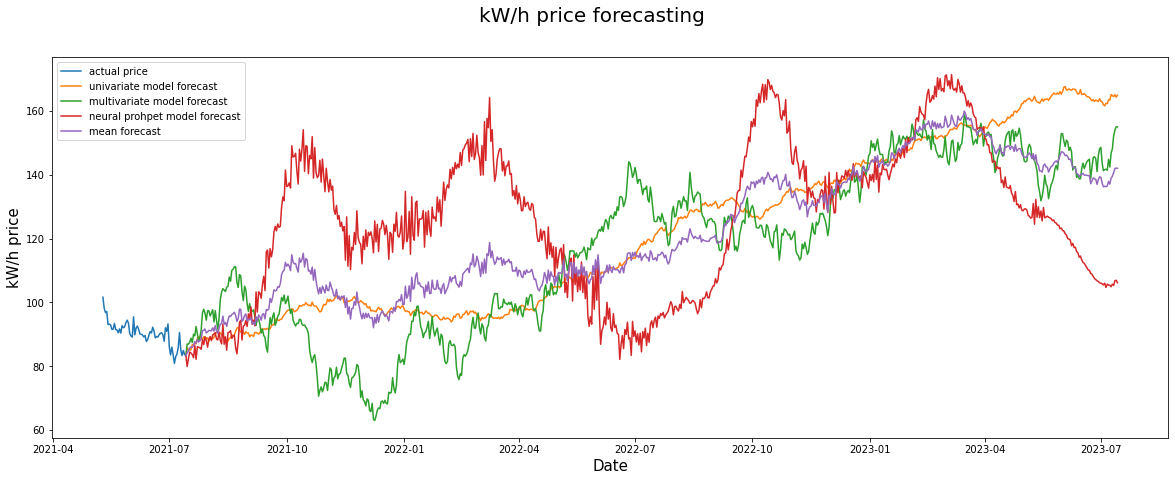

In [15]:
graficar(7800)

# Ejemplos:

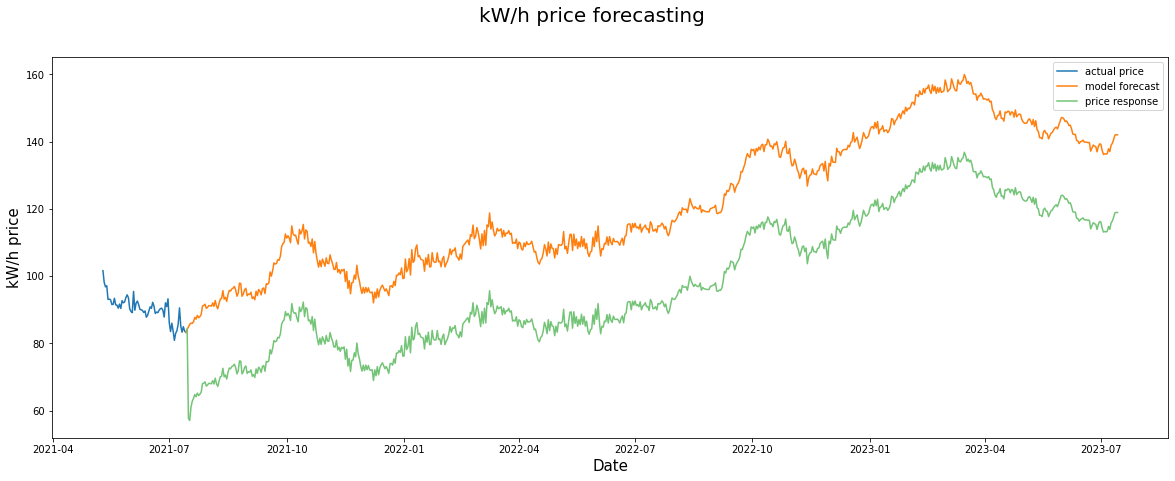

In [33]:
""" 
Choque sin convergencia 
en la fecha '2021-07-16', 
en el modelo 'kW/h price mean models', 
sobre la variable 'HYDRAULIC_availability'
de aumento del 10%
"""
simular_choque(7800, '2021-07-16', 'kW/h price mean models', 'HYDRAULIC_availability', 10)


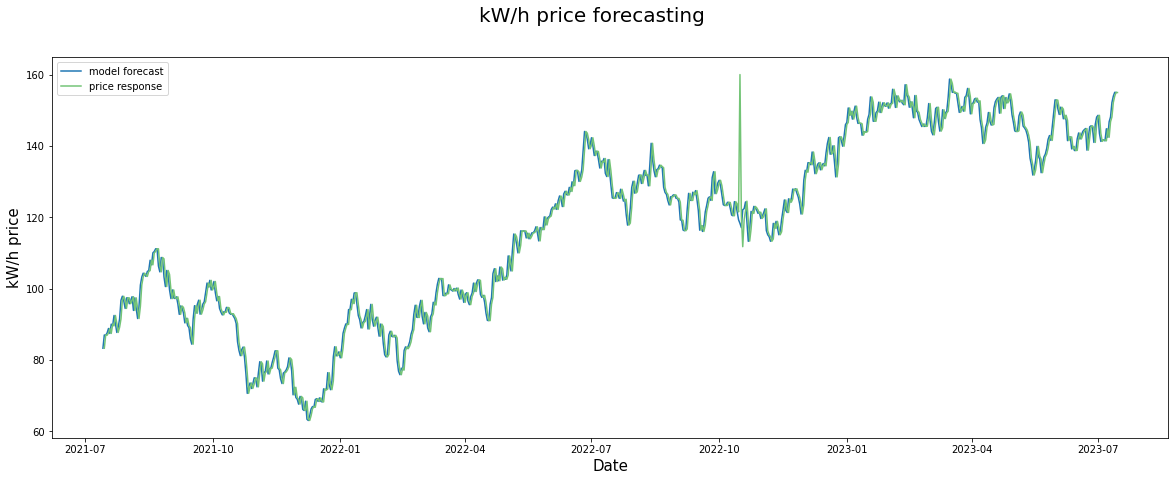

In [34]:
""" 
Choque con convergencia
en la fecha '2022-10-15', 
en el modelo 'kW/h price SARIMAX', 
sobre la variable 'HYDRAULIC_availability'
de caida del 15%
"""
simular_choque_con_convergencia(9000, '2022-10-15', 'kW/h price SARIMAX', 'HYDRAULIC_availability', -15)

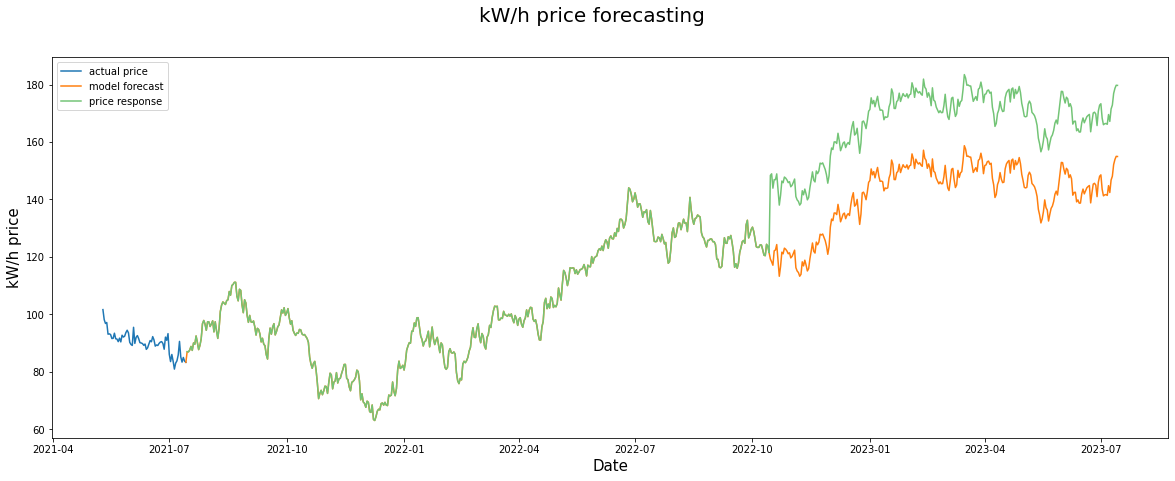

In [35]:
""" 
Choque sin convergencia
en la fecha '2022-10-15', 
en el modelo 'kW/h price SARIMAX', 
sobre la variable 'THERMAL_availability'
de caida del 30%
"""

simular_choque(7800, '2022-10-15', 'kW/h price SARIMAX', 'THERMAL_availability', -30)

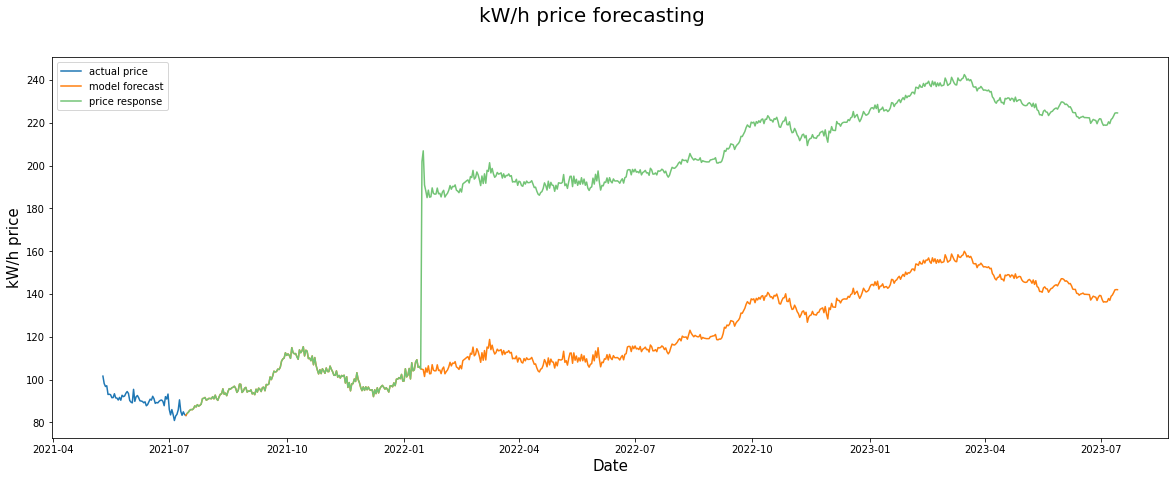

In [19]:
""" 
Choque sin convergencia
en la fecha '2022-01-15', 
en el modelo 'kW/h price mean models', 
sobre la variable 'THERMAL_availability'
caída del 100%
"""

simular_choque(7800, '2022-01-15', 'kW/h price mean models', 'THERMAL_availability', -100)


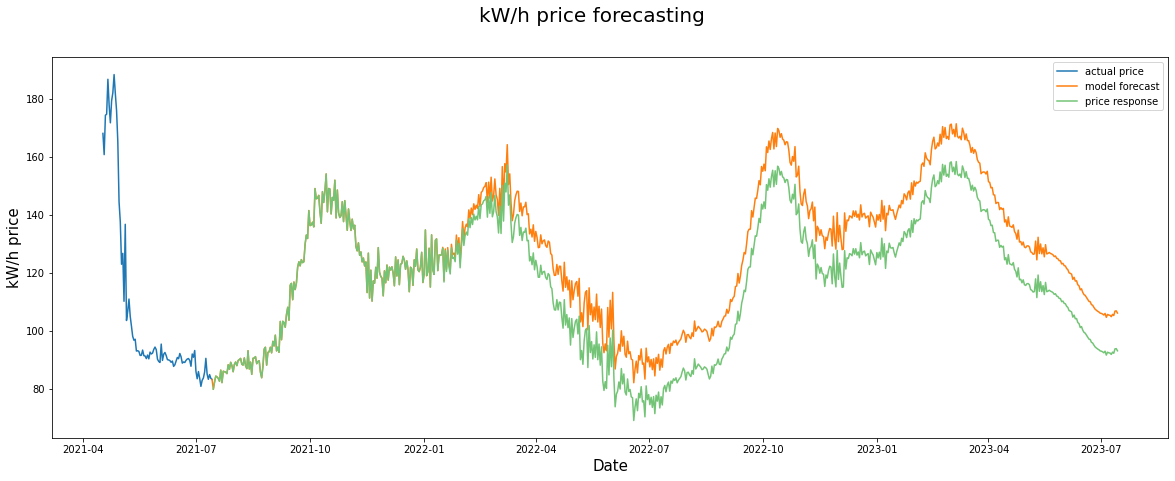

In [20]:
""" 
Choque sin convergencia
en la fecha '2021-10-15', 
en el modelo 'kW/h price Neural Prophet', 
sobre la variable 'Cumulative_Volume_(Mm3)'
caida de 0.4% por 100 días consecutivos
"""
simular_choque(7777, '2022-01-15', 'kW/h price Neural Prophet', 'Cumulative_Volume_(Mm3)', -0.4)

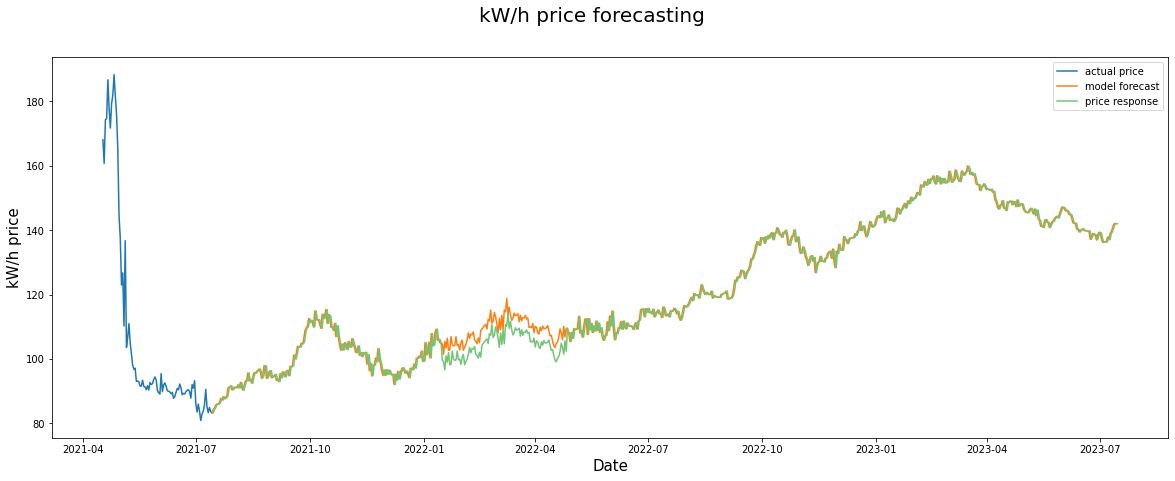

In [21]:
""" 
Choque con convergencia
en la fecha '2021-10-15', 
en el modelo 'kW/h price mean models', 
sobre la variable 'Cumulative_Volume_(Mm3)'
caida de 14% por 100 días consecutivos
"""


simular_choque_con_convergencia(7777, '2022-01-15', 'kW/h price mean models', 'Cumulative_Volume_(Mm3)', -14)

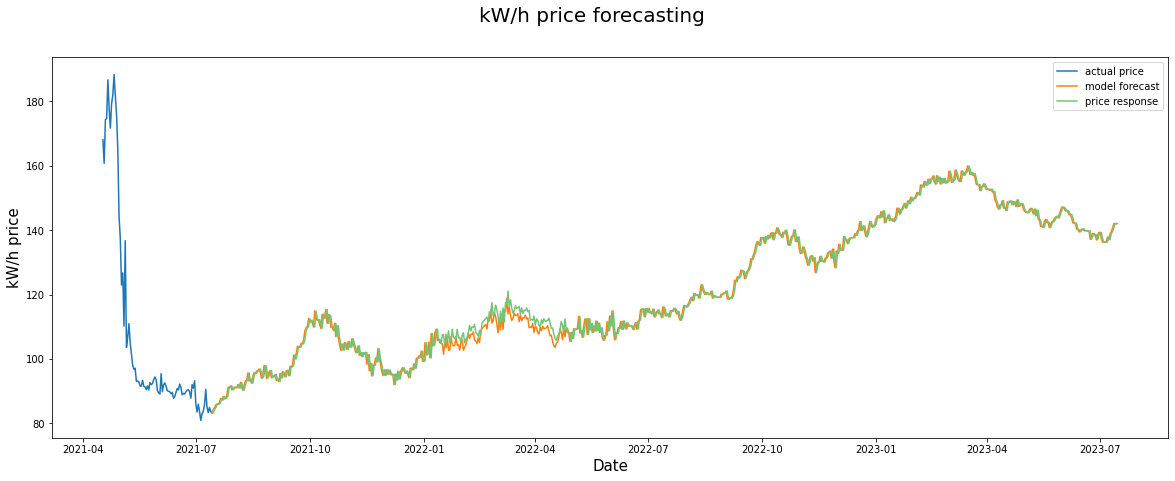

In [22]:
""" 
Choque con convergencia
en la fecha '2021-10-15', 
en el modelo 'kW/h price mean models', 
sobre la variable 'Cumulative_THERMAL availability'
caida de 4% por 100 días consecutivos
"""


simular_choque_con_convergencia(7777, '2022-01-15', 'kW/h price mean models', 'Cumulative_THERMAL availability', -4)


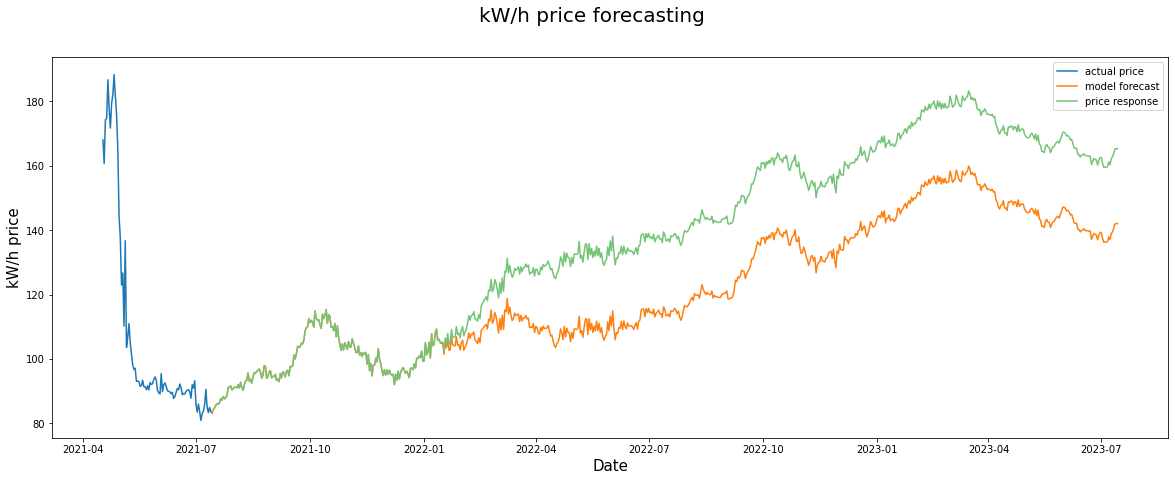

In [23]:
""" 
Choque sin convergencia
en la fecha '2021-10-15', 
en el modelo 'kW/h price mean models', 
sobre la variable 'Cumulative_THERMAL availability'
caida de 0.4% por 100 días consecutivos
"""


simular_choque(7777, '2022-01-15', 'kW/h price mean models', 'Cumulative_THERMAL availability', -0.4)


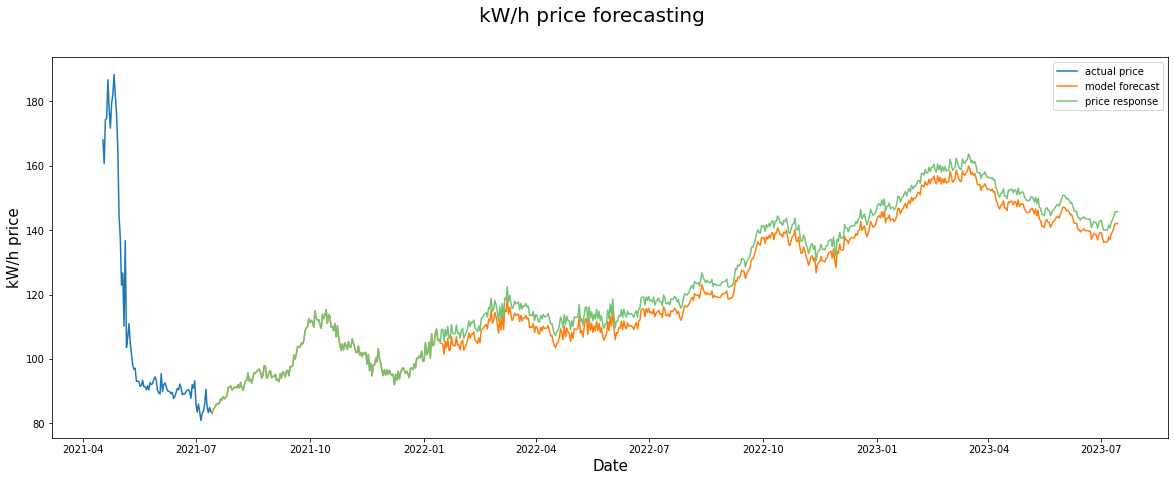

In [24]:
""" 
Choque sin convergencia
en la fecha '2021-10-15', 
en el modelo 'kW/h price mean models', 
sobre la variable 'Daily_useful_Volume_(gWh)'
caida de 15%
"""

simular_choque(7777, '2022-01-15', 'kW/h price mean models', 'Daily_useful_Volume_(gWh)', -15)

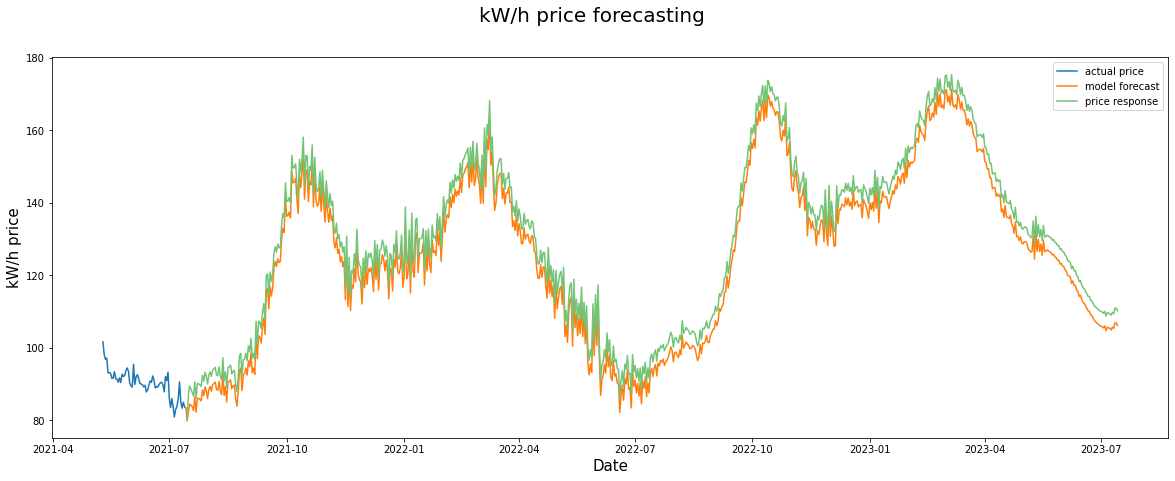

In [25]:
""" 
Choque sin convergencia 
en la fecha '2021-07-16', 
en el modelo 'kW/h price Neural Prophet', 
sobre la variable 'flow_contribution'
de aumento del 10%
"""
simular_choque(7800, '2021-07-16', 'kW/h price Neural Prophet', 'flow_contribution', 10)
#simular_choque_con_convergencia(7800, '2021-07-16', 'kW/h price Neural Prophet', 'flow_contribution', 10)

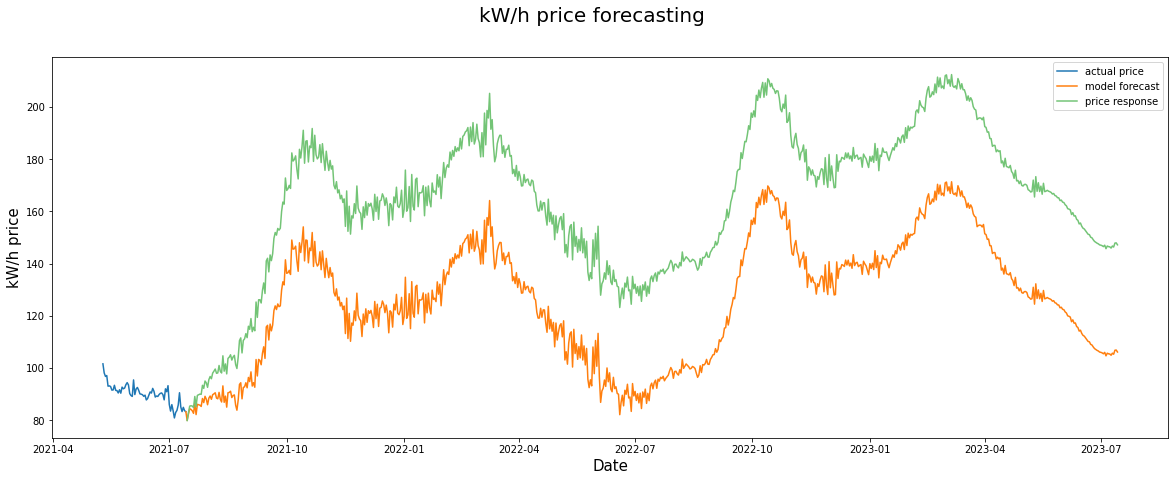

In [36]:
""" 
Choque sin convergencia 
en la fecha '2021-07-16', 
en el modelo 'kW/h price Neural Prophet', 
sobre la variable 'Cumulative_flow_contribution'
de aumento del 1% por 100 días consecutivos
"""
simular_choque(7800, '2021-07-16', 'kW/h price Neural Prophet', 'Cumulative_flow_contribution', 1)


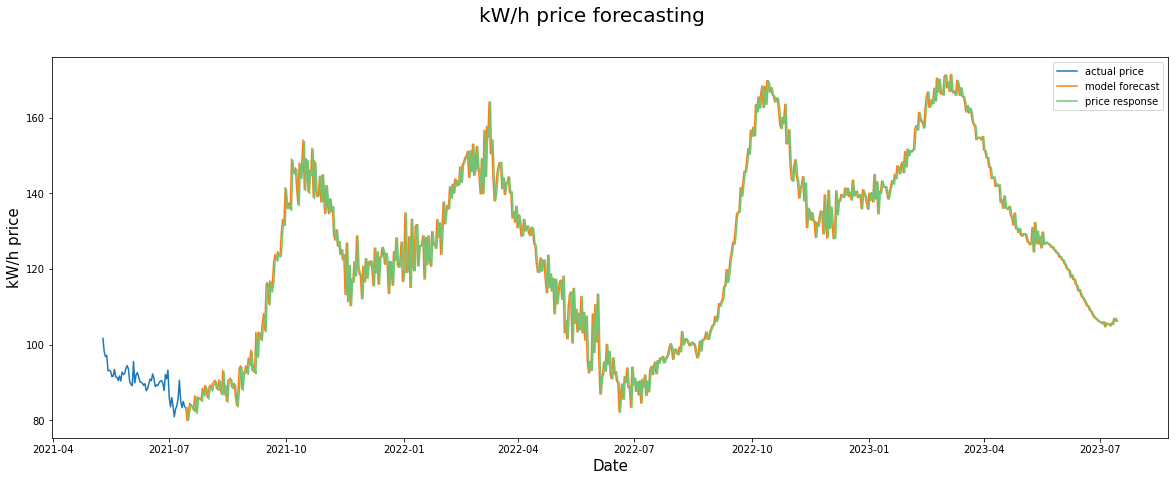

In [37]:
""" 
Choque con convergencia 
en la fecha '2021-07-16', 
en el modelo 'kW/h price Neural Prophet', 
sobre la variable 'Cumulative_flow_contribution'
de aumento del 1% por 100 días consecutivos
"""
simular_choque_con_convergencia(7800, '2021-07-16', 'kW/h price Neural Prophet', 'Cumulative_daily_volume_(Mm3)', 1)


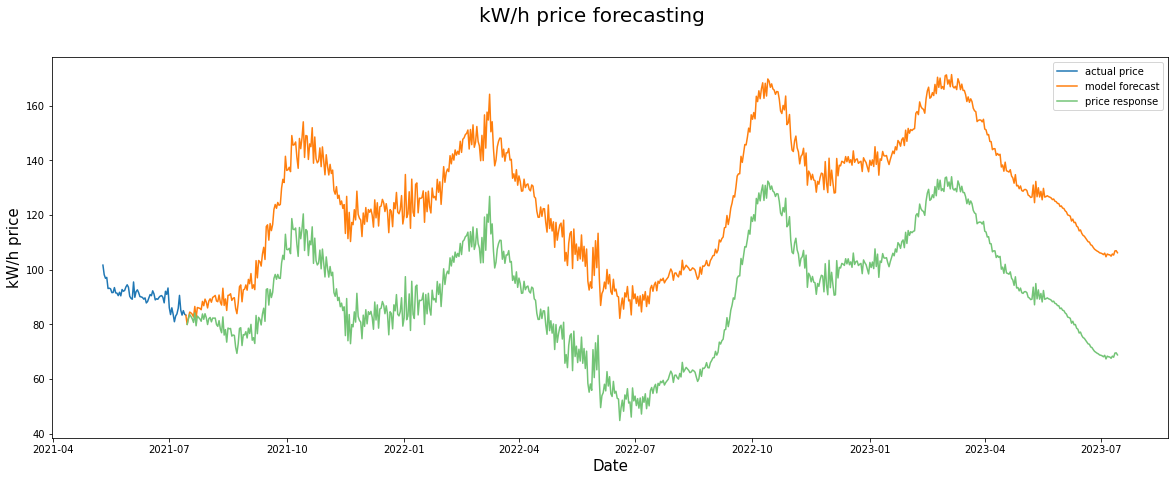

In [38]:
""" 
Choque sin convergencia 
en la fecha '2021-07-16', 
en el modelo 'kW/h price Neural Prophet', 
sobre la variable 'Cumulative_flow_contribution'
de aumento del 1% por 100 días consecutivos
"""
simular_choque(7800, '2021-07-16', 'kW/h price Neural Prophet', 'Cumulative_daily_volume_(Mm3)', 1)


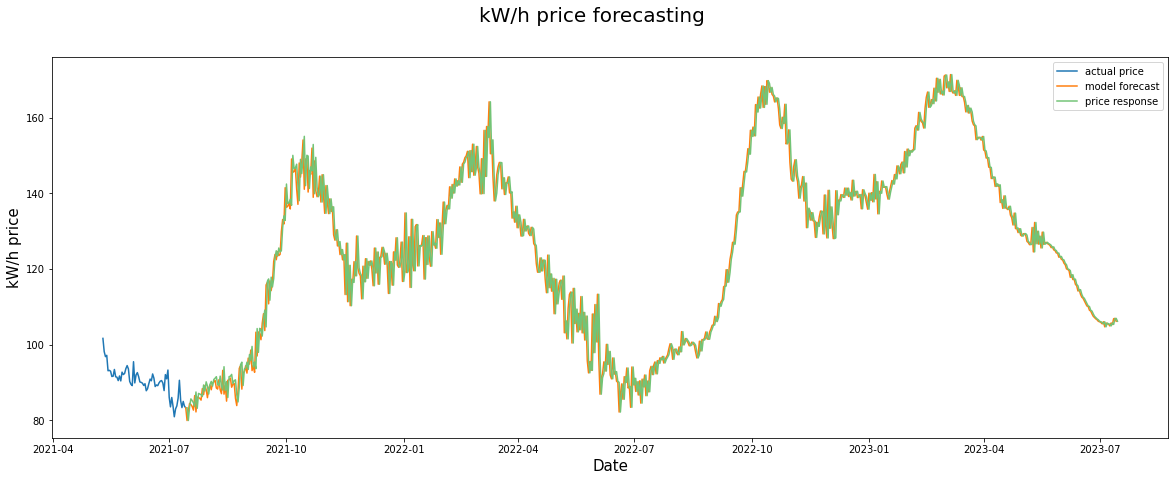

In [39]:
""" 
Choque con convergencia 
en la fecha '2021-07-16', 
en el modelo 'kW/h price Neural Prophet', 
sobre la variable 'Cumulative_Volume_(Mm3)'
de aumento del 3% por 100 días consecutivos
"""
simular_choque_con_convergencia(7800, '2021-07-16', 'kW/h price Neural Prophet', 'Cumulative_Volume_(Mm3)', 3)


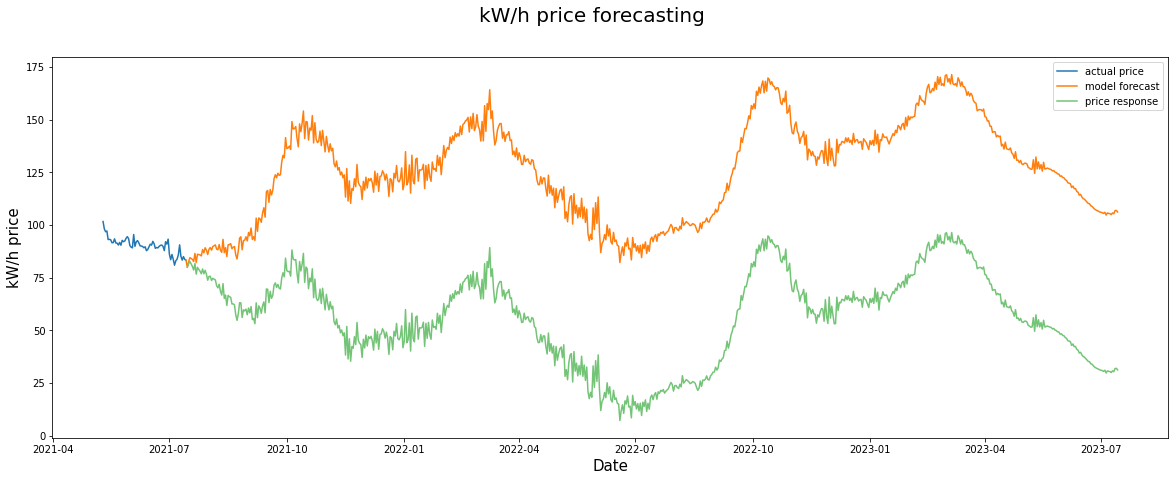

In [40]:
""" 
Choque sin convergencia 
en la fecha '2021-07-16', 
en el modelo 'kW/h price Neural Prophet', 
sobre la variable 'Cumulative_Daily_useful_Volume_(gWh)'
de aumento del 3% por 100 días consecutivos
"""
simular_choque(7800, '2021-07-16', 'kW/h price Neural Prophet', 'Cumulative_Daily_useful_Volume_(gWh)', 3)